In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!rm -rf lasenet # clear up dir if any
!git clone https://github.com/ti55987/lasenet

Cloning into 'lasenet'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 108 (delta 41), reused 90 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (108/108), 503.82 KiB | 23.99 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [ ]:
%cd lasenet
%ls

/content/lasenet
benchmarks/      eval.ipynb     pretrained.sh*  training/
colab_example/   LICENSE        README.md       training.ipynb
environment.yml  mice_fitting/  simulation/     utils/


In [ ]:

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from utils.feature_utils import (
    get_onehot_features,
    get_feature_list_by_model,
    get_latent_labels,
    CognitiveModel,
)
from utils.training_utils import set_seed

from training.models import create_model

# User customization part

In [ ]:
DRIVE_DIR = '/content/gdrive/MyDrive/LayesNet Training Data'
RESULT_DIR = '/content/gdrive/MyDrive/LaseNet_Result'
# parameter list you want to recover
target_parameter_name = ['unchosen_rpe_history'] # Change to your parameter name

# CHANGE TO YOUR OWN FEATURES
feature_list = ['actions']#  e.g. 'actions', 'rewards', 'stimuli'
training_data_file_path = f'{DRIVE_DIR}/Combined_Simulations_Sampled.csv'
#test_data_file_path = f'{DRIVE_DIR}/Comebined_Simulations_Biased.csv'

# Process data

## Example data - skip this if you don't have problem processing data

In [ ]:
import tqdm
import random

from simulation.prl.simulate_4prl import simulate_4prl

model_name = CognitiveModel.PRL4
num_agents = 50

num_trials = 500

data_list = []
for a in tqdm.tqdm(range(num_agents)):
    rand_beta = random.uniform(1e-4, 10)
    rand_alpha = random.uniform(1e-4, 1)
    rand_neg_alpha = random.uniform(1e-4, 1)
    rand_stickiness = random.uniform(0, 1)

    parameters = [rand_beta, rand_alpha, rand_neg_alpha, rand_stickiness]
    example = simulate_4prl(parameters, num_trials, 0.8, 15, 2, a)
    data_list.append(example)

example_df = pd.concat(data_list)
example_df.head(3)


100%|██████████| 50/50 [00:01<00:00, 36.19it/s]


,agentid,actions,correct_actions,rewards,isswitch,iscorrectaction,trials,rpe_history,unchosen_rpe_history,alpha,beta,neg_alpha,stickiness
0,0,0,0,1,0,1,0,0.500000,-0.500000,0.559816,4.52385,0.924218,0.46565
1,0,0,0,1,0,1,1,0.220092,-0.220092,0.559816,4.52385,0.924218,0.46565
2,0,0,0,1,0,1,2,0.096881,-0.096881,0.559816,4.52385,0.924218,0.46565


In [ ]:
# feature_list is rewards and actions as they are observable input variables.
# The shape is (10, 500, 4) = (num_agent, num_trial, feature_dim)
print(get_onehot_features(example_df, ['actions', 'rewards']).shape)
# target_parameter_name is rpe_history as we want to recover it
# The shape is (10, 500) = (num_agent, num_trial)
print(get_latent_labels(example_df, 'rpe_history').shape)

(50, 500, 4)
(50, 500)


## Read your own data

In [ ]:
#agentid: 1~25 #actions: estimated reward #rewards: wind_condition #trials:trials , #rpe_history:volatility
import pandas as pd
import numpy as np

def trim_trials_per_agent(data, agent_col='agentid', trial_col='trials', trim_first=0, trim_last=0):
    trimmed_data = []
    for agent_id, agent_df in data.groupby(agent_col):
        agent_df_sorted = agent_df.sort_values(by=trial_col)
        if trim_last > 0:
            trimmed = agent_df_sorted.iloc[trim_first:-trim_last]
        else:
            trimmed = agent_df_sorted.iloc[trim_first:]  # slice to end
        trimmed_data.append(trimmed)
    return pd.concat(trimmed_data, ignore_index=True)

def get_raw_features(data, input_list, reshape=False):
    features = []

    if reshape:
        n_agent = len(data["agentid"].unique())
        n_trial = len(data["trials"].unique())

    for col in input_list:
        if col in data:
            raw_values = data[col].values.astype(np.float32)

            if reshape:
                if raw_values.shape[0] != n_agent * n_trial:
                    raise ValueError(f"Data shape {raw_values.shape[0]} does not match expected shape {n_agent * n_trial}.")
                try:
                    # Reshape to (n_agent, n_trial, 1)
                    raw_values = raw_values.reshape((n_agent, n_trial, 1))
                except Exception as e:
                    raise ValueError(f"Cannot reshape {len(raw_values)} values to shape ({n_agent}, {n_trial}, 1): {str(e)}")

            features.append(raw_values)

    # Stack along last axis → (n_agent, n_trial, n_features)
    output = np.concatenate(features, axis=-1 if reshape else 1)
    return output


# Load data
original_data = pd.read_csv(training_data_file_path)

# Trim start and end trials
data = trim_trials_per_agent(original_data)
#data["actions"] = pd.cut(data["actions"], bins=100, labels=False)
#data["rewards"] = pd.cut(data["rewards"], bins=100, labels=False)

# Agent-level split
unique_agents = data["agentid"].unique()
np.random.seed(33)
np.random.shuffle(unique_agents)

n_total = len(unique_agents)
n_test = n_val = int(n_total * 0.1)
n_train = n_total - n_val - n_test

train_agents = unique_agents[:n_train]
val_agents = unique_agents[n_train:n_train + n_val]
test_agents = unique_agents[n_train + n_val:]

train_data = data[data["agentid"].isin(train_agents)].sort_values(["agentid", "trials"])
val_data   = data[data["agentid"].isin(val_agents)].sort_values(["agentid", "trials"])
test_data  = data[data["agentid"].isin(test_agents)].sort_values(["agentid", "trials"])

# Extract features and labels using raw continuous data
X_train = get_raw_features(train_data, feature_list, reshape=True)
y_train = get_latent_labels(train_data, target_parameter_name)

X_val = get_raw_features(val_data, feature_list, reshape=True)
y_val = get_latent_labels(val_data, target_parameter_name)

X_test = get_raw_features(test_data, feature_list, reshape=True)
y_test = get_latent_labels(test_data, target_parameter_name)

# Final checks
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)
print("First 5 labels:", y_train[:5])
print(train_data.head(3))
print(X_train.shape)

Train: (4000, 377, 1) (4000, 377)
Val:   (500, 377, 1) (500, 377)
Test:  (500, 377, 1) (500, 377)
First 5 labels: [[0.08236759 0.09102267 0.09655301 ... 0.31238064 0.3077565  0.313851  ]
 [0.08263312 0.08434636 0.08527877 ... 0.16811663 0.16687253 0.16481352]
 [0.08271676 0.08284573 0.08881997 ... 0.44368523 0.4473779  0.45832938]
 [0.08240535 0.08317056 0.08853094 ... 0.45230025 0.4538826  0.46222767]
 [0.08260535 0.0880272  0.08883205 ... 0.7280528  0.74013484 0.7449074 ]]
     agentid   actions  correct_actions  rewards  isswitch  iscorrectaction  \
754        2 -4.794933              NaN     -3.6       NaN              NaN   
755        2 -5.047396              NaN     -3.6       NaN              NaN   
756        2 -5.183995              NaN     -3.6       NaN              NaN   

     trials  rpe_history  unchosen_rpe_history  alpha  beta  neg_alpha  \
754       1     0.300926              0.082368    NaN   NaN        NaN   
755       2     0.411199              0.091023    NaN  

# Training Models

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
set_seed(33)

## CHANGE ME ##
batch_size = 128
units = 256
dropout = 0.12492302802998448
dropout1 =  0.012615786263324952
dropout2 =  0.026895223609922816
learning_rate = 0.0003
###############Search({'batch_size': 128, 'continuous_output_dim': 1, 'discrete_output_dim': 0, 'dropout': 0.089600989124067, 'dropout1': 0.028192511172676654, 'dropout2': 0.02884707013684206, 'epochs': 25, 'feature_dim': 16733, 'learning_rate': 0.0003, 'units': 96})
#{'batch_size': 128, 'continuous_output_dim': 1, 'discrete_output_dim': 0, 'dropout': 0.12492302802998448, 'dropout1': 0.012615786263324952, 'dropout2': 0.026895223609922816, 'epochs': np.int64(48), 'feature_dim': 420, 'learning_rate': 0.0003, 'units': 256, 'steps_per_epoch': 1}
n_agents = data["agentid"].nunique()
n_trial = data[data["agentid"] == data["agentid"].iloc[0]].shape[0]
variable = 'Stochasity_Sampled_OnlyActions'
identifier = f'{variable}_A{n_agents}_{n_trial}t_B{batch_size}_U{units}_D{dropout}_D{dropout1}_D{dropout2}'
print(identifier)

lasenet = create_model(
    feature_dim=X_train.shape[-1],
    continuous_output_dim=1,
    discrete_output_dim=0,
    units=units,
    dropout=dropout,
    dropout1=dropout1,
    dropout2=dropout2,
)

optimizer = Adam(learning_rate=learning_rate)
lasenet.compile(
    loss={
        "continuous_latent": "mse",
    },
    loss_weights={"continuous_latent": 1},
    optimizer=optimizer,
)

Random seed set as 33
Stochasity_Sampled_OnlyActions_A5000_377t_B128_U256_D0.12492302802998448_D0.012615786263324952_D0.026895223609922816


## Training

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)]
start = time.time()

history = lasenet.fit(
  X_train,
  y=y_train,
  batch_size=batch_size,
  epochs=600, # we set to 600 in our work
  verbose=2,
  callbacks=callbacks,
  validation_data=(X_val, y_val),
)

end = time.time()
print(end-start)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/600
32/32 - 9s - 281ms/step - loss: 487.9071 - val_loss: 466.7143
Epoch 2/600
32/32 - 7s - 217ms/step - loss: 439.5164 - val_loss: 417.6431
Epoch 3/600
32/32 - 7s - 218ms/step - loss: 333.6875 - val_loss: 273.2586
Epoch 4/600
32/32 - 7s - 218ms/step - loss: 220.2503 - val_loss: 201.2467
Epoch 5/600
32/32 - 7s - 220ms/step - loss: 144.1131 - val_loss: 117.2688
Epoch 6/600
32/32 - 7s - 219ms/step - loss: 116.7043 - val_loss: 91.2243
Epoch 7/600
32/32 - 7s - 217ms/step - loss: 79.1054 - val_loss: 75.9646
Epoch 8/600
32/32 - 7s - 218ms/step - loss: 62.8176 - val_loss: 57.1314
Epoch 9/600
32/32 - 7s - 218ms/step - loss: 56.4772 - val_loss: 49.1943
Epoch 10/600
32/32 - 7s - 219ms/step - loss: 48.8655 - val_loss: 44.8322
Epoch 11/600
32/32 - 7s - 220ms/step - loss: 43.7147 - val_loss: 40.1147
Epoch 12/600
32/32 - 7s - 218ms/step - loss: 40.3687 - val_loss: 38.0578
Epoch 13/600
32/32 - 7s - 219ms/step - loss: 38.4094 - val_loss: 35.3559
Epoch 14/600
32/32 - 7s - 217ms/step - loss: 36.6

In [ ]:
result = pd.DataFrame(history.history)
ax = sns.lineplot(result)
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

# Save the training results
plt.savefig(f'{RESULT_DIR}/{identifier}.png')
lasenet.save(f'{RESULT_DIR}/{identifier}_model.keras')

NameError: name 'pd' is not defined

# Hyperparameter turning

In [ ]:
def get_model(parms):
    lasenet = create_model(
        parms["feature_dim"],
        parms["discrete_output_dim"],
        parms["continuous_output_dim"],
        parms["units"],
        parms["dropout"],
        parms["dropout1"],
        parms["dropout2"],
    )
    optimizer = Adam(learning_rate=parms["learning_rate"])
    lasenet.compile(
        loss={
            "continuous_latent": "mse",
        },
        loss_weights={"continuous_latent": 1},
        optimizer=optimizer,
    )
    return lasenet

## Model Evaluation

In [ ]:
# load previous trained models
import tensorflow as tf
best_model = tf.keras.models.load_model(f'{RESULT_DIR}/{identifier}_model.keras')

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
(500, 377, 1)


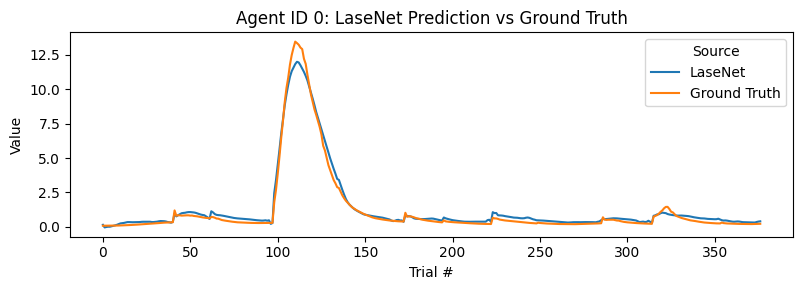

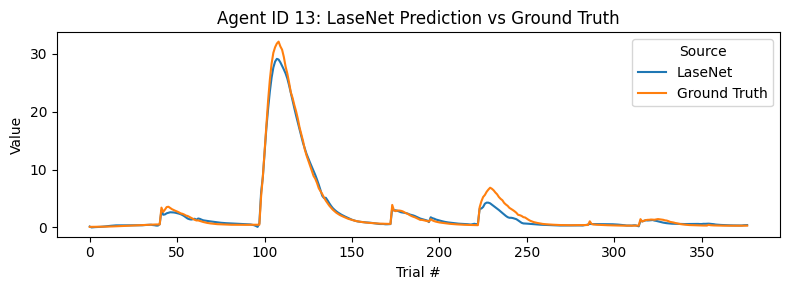

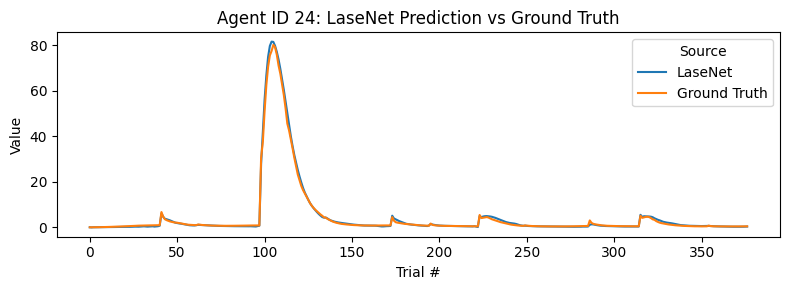

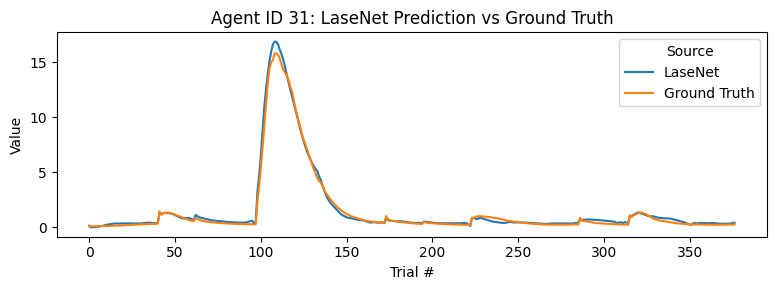

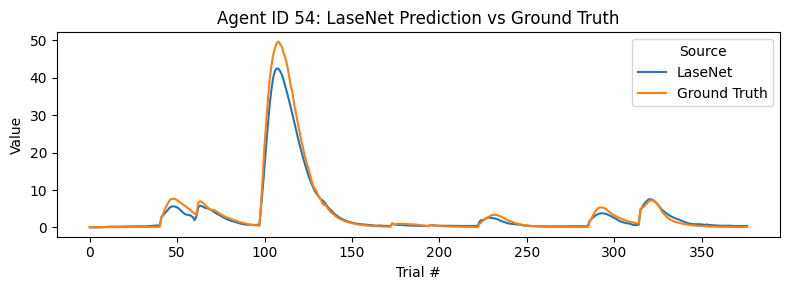

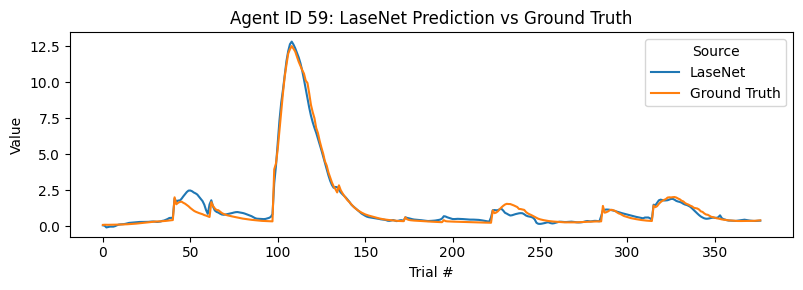

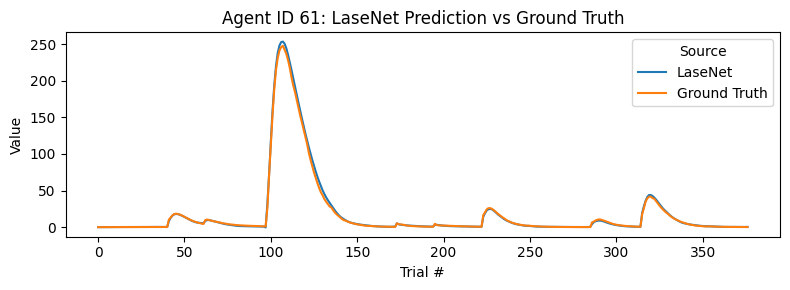

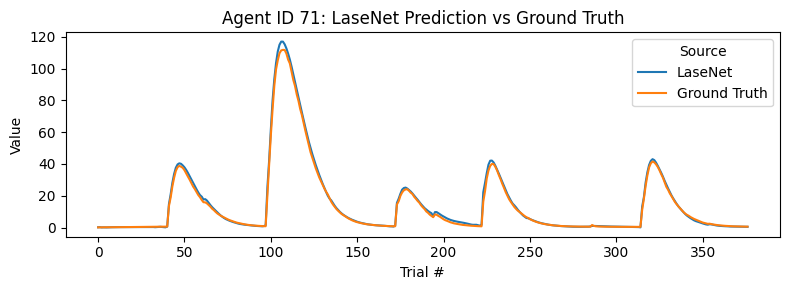

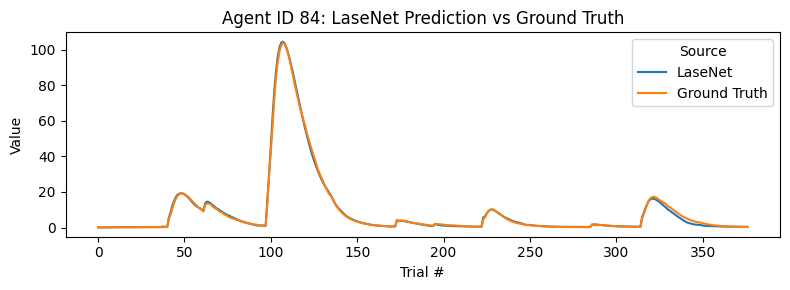

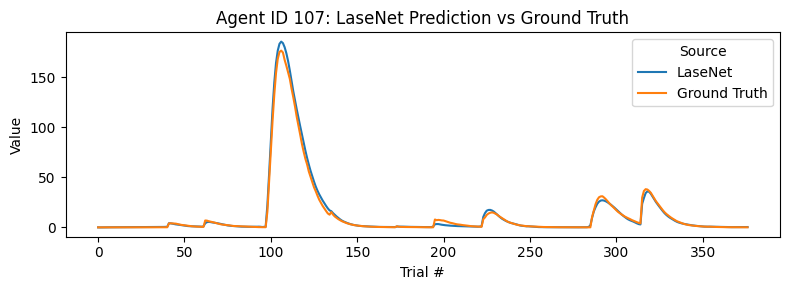

Overall RMSE: 1.4499


In [ ]:
predicted = best_model.predict(X_val)
print(predicted.shape)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get actual agent IDs from val
agent_ids = val_data["agentid"].unique()

# How many agents you want to plot
max_agent = min(10, predicted.shape[0])
num_trials = predicted.shape[1]

# Create one plot per agent
for i in range(max_agent):
    df = pd.DataFrame({
        "Trial": np.arange(num_trials),
        "LaseNet": predicted[i, :].flatten().astype(float),
        "Ground Truth": y_val[i, :].flatten().astype(float)
    })

    df = df.melt(id_vars="Trial", var_name="Source", value_name="Value")

    plt.figure(figsize=(8, 3))
    sns.lineplot(data=df, x="Trial", y="Value", hue="Source")
    plt.title(f"Agent ID {agent_ids[i]}: LaseNet Prediction vs Ground Truth")
    plt.xlabel("Trial #")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

from sklearn.metrics import mean_squared_error

# Flatten both arrays for RMSE across all agents and trials
rmse = np.sqrt(mean_squared_error(y_val.flatten(), predicted.flatten()))
print(f"Overall RMSE: {rmse:.4f}")

 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
(500, 377, 1)


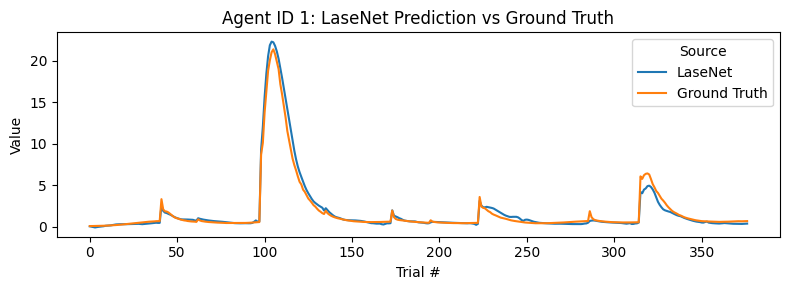

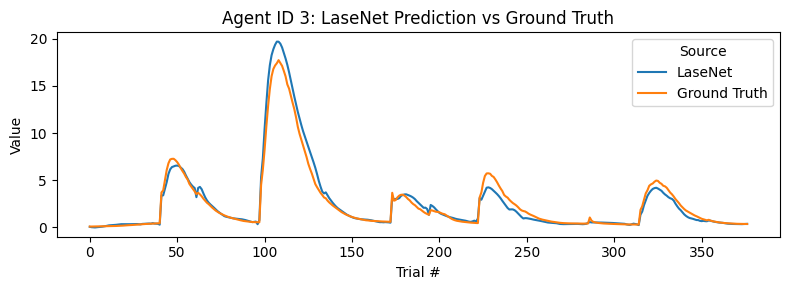

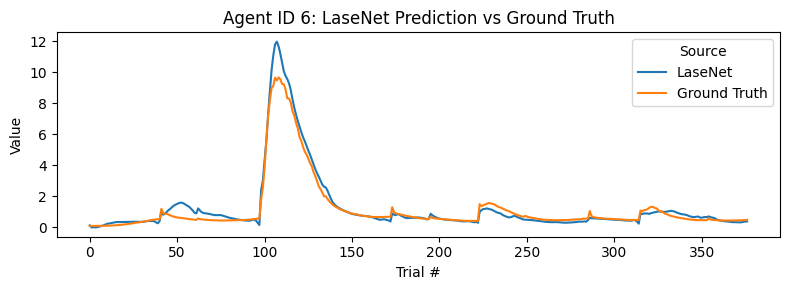

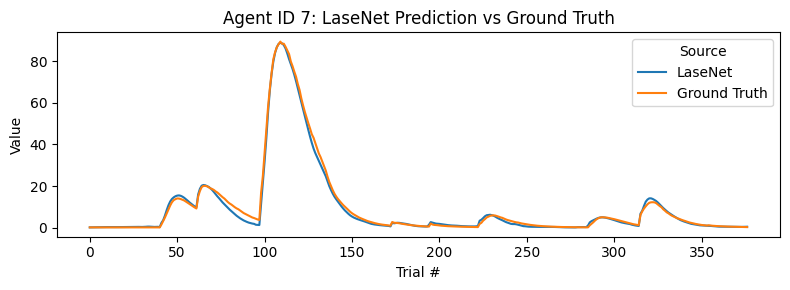

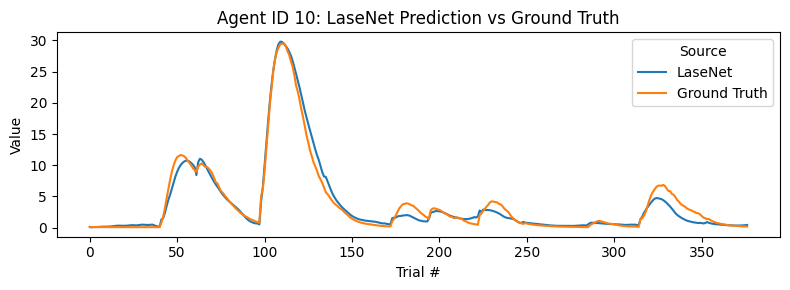

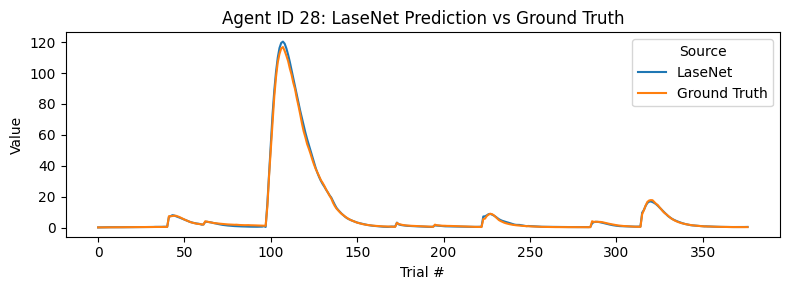

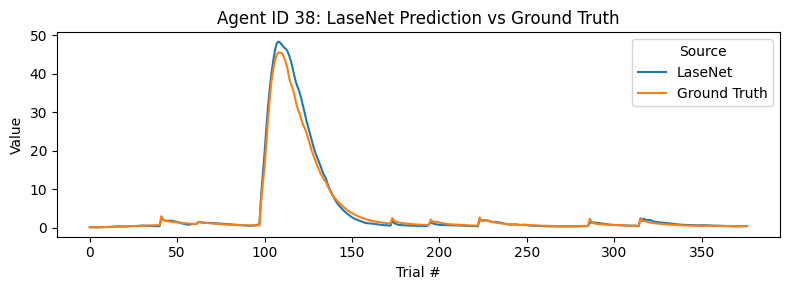

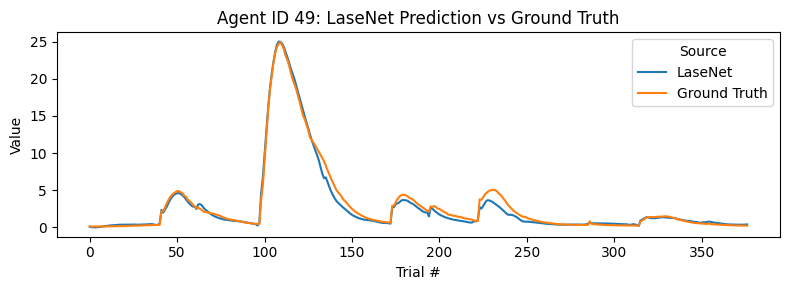

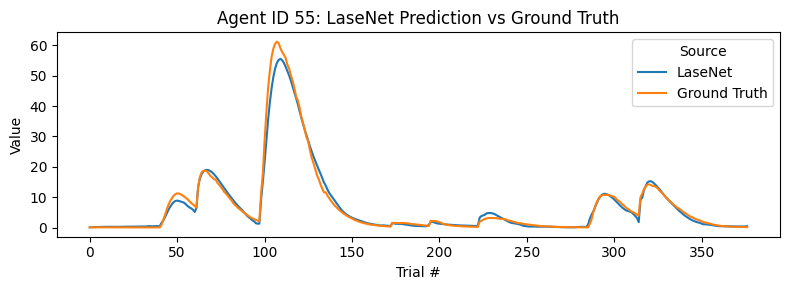

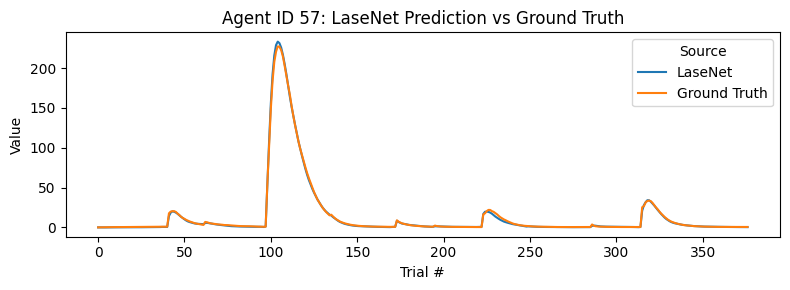

Overall RMSE: 1.4362


In [ ]:
predicted = best_model.predict(X_test)
print(predicted.shape)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get actual agent IDs from val
agent_ids = test_data["agentid"].unique()

# How many agents you want to plot
max_agent = min(10, predicted.shape[0])
num_trials = predicted.shape[1]

# Create one plot per agent
for i in range(max_agent):
    df = pd.DataFrame({
        "Trial": np.arange(num_trials),
        "LaseNet": predicted[i, :].flatten().astype(float),
        "Ground Truth": y_test[i, :].flatten().astype(float)
    })

    df = df.melt(id_vars="Trial", var_name="Source", value_name="Value")

    plt.figure(figsize=(8, 3))
    sns.lineplot(data=df, x="Trial", y="Value", hue="Source")
    plt.title(f"Agent ID {agent_ids[i]}: LaseNet Prediction vs Ground Truth")
    plt.xlabel("Trial #")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

from sklearn.metrics import mean_squared_error

# Flatten both arrays for RMSE across all agents and trials
rmse = np.sqrt(mean_squared_error(y_test.flatten(), predicted.flatten()))
print(f"Overall RMSE: {rmse:.4f}")

In [ ]:
import pandas as pd
import numpy as np

# 1. Load actions from Google Drive Excel (columns = agents, rows = trials)
actions_df = pd.read_excel("/content/gdrive/MyDrive/LaseNets/NonMotor_LVLS.xlsx", header=None)
actions_trimmed = actions_df.T.to_numpy() * 10000 / (-270)  # Shape: (n_agents, n_trials)

# 2. Get rewards from your original test_data (already aligned and trimmed)
# Assuming test_data is sorted by agentid and trials
rewards_df = data.pivot(index="trials", columns="agentid", values="rewards")
rewards_trimmed = rewards_df.T.to_numpy()  # Shape: (n_agents, n_trials)
rewards_trimmed = rewards_trimmed[:22]
print(actions_trimmed.shape)
print(rewards_trimmed.shape)
# 3. Stack features along last axis to match (n_agents, n_trials, n_features)
actions_trimmed = actions_trimmed[..., np.newaxis]  # shape: (n_agents, n_trials, 1)
rewards_trimmed = rewards_trimmed[..., np.newaxis]

X_test_new = np.concatenate([actions_trimmed, rewards_trimmed], axis=-1)
predicted = best_model.predict(X_test_new)
print(predicted.shape)


predicted_stochasity_flat = predicted.reshape(-1)
n_agents, n_trials, _ = predicted.shape
# Add identifiers (agent ID and trial number)
agent_ids = np.repeat(np.arange(n_agents), n_trials)
trial_nums = np.tile(np.arange(n_trials), n_agents)

# Combine into a DataFrame
df_out = pd.DataFrame({
    'agent_id': agent_ids,
    'trial': trial_nums,
    'predicted_stochasity': predicted_stochasity_flat
})

# Export only predicted volatility
df_out.to_excel("predicted_stochasity_NonMotor_Simple.xlsx", index=False)
from google.colab import files
files.download("predicted_stochasity_NonMotor_Simple.xlsx")


(22, 377)
(22, 377)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
(22, 377, 1)


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

agents: 22, trials: 377, features: 2
Agent 0, first 5 trials:
  actions : [ 8.6953125  -9.7078125  -9.21875    -5.22604167 -5.90625   ]
  rewards : [-3.6 -3.6 -3.6 -3.6 -3.6]
Actions  – min: -2489.894035345726 max: 856.6222854123963 mean: -0.8392204933308473 std: 33.233161270673094
Rewards  – min: -14.4 max: 14.4 mean: -0.4488063660477455 std: 9.621911053179147


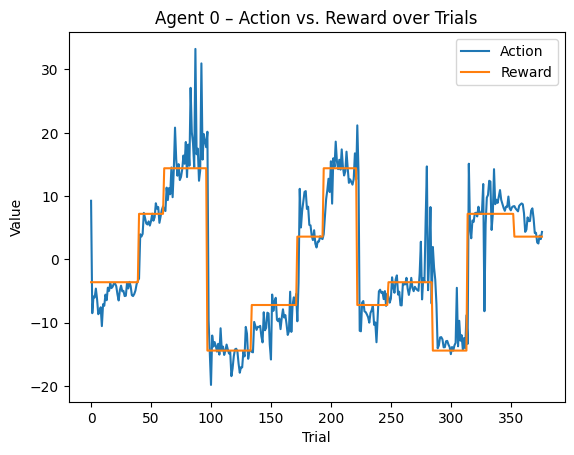

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose X_test_new has shape (n_agents, n_trials, 2),
# where [:, :, 0] = actions and [:, :, 1] = rewards.

n_agents, n_trials, n_feats = X_test_new.shape
print(f"agents: {n_agents}, trials: {n_trials}, features: {n_feats}")

# 1) Print out the first 5 trials of the first agent:
print("Agent 0, first 5 trials:")
print("  actions :", X_test_new[1, :5, 0])
print("  rewards :", X_test_new[1, :5, 1])

# 2) Summary statistics across all agents/trials
print("Actions  – min:", np.min(X_test_new[:,:,0]),
      "max:", np.max(X_test_new[:,:,0]),
      "mean:", np.mean(X_test_new[:,:,0]),
      "std:", np.std(X_test_new[:,:,0]))
print("Rewards  – min:", np.min(X_test_new[:,:,1]),
      "max:", np.max(X_test_new[:,:,1]),
      "mean:", np.mean(X_test_new[:,:,1]),
      "std:", np.std(X_test_new[:,:,1]))

# 3) Plot the two features for one agent over trials:
agent_idx = 0
plt.figure()
plt.plot(X_test_new[agent_idx, :, 0], label="Action")
plt.plot(X_test_new[agent_idx, :, 1], label="Reward")
plt.xlabel("Trial")
plt.ylabel("Value")
plt.title(f"Agent {agent_idx} – Action vs. Reward over Trials")
plt.legend()
plt.show()


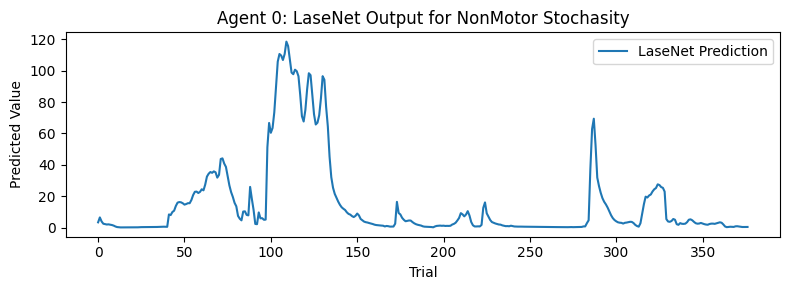

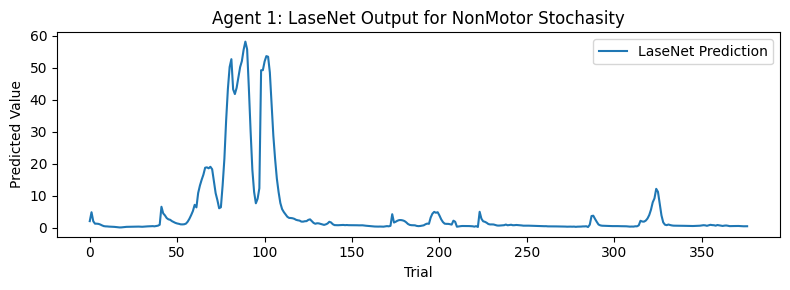

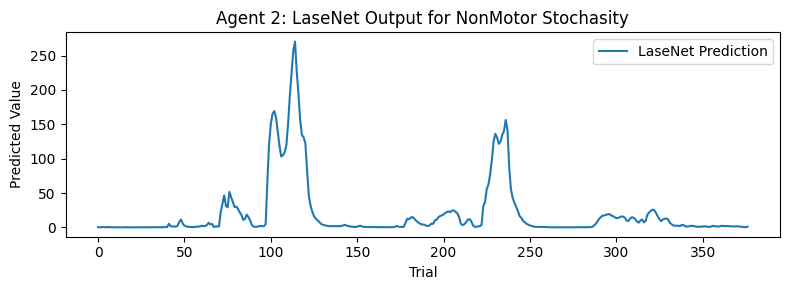

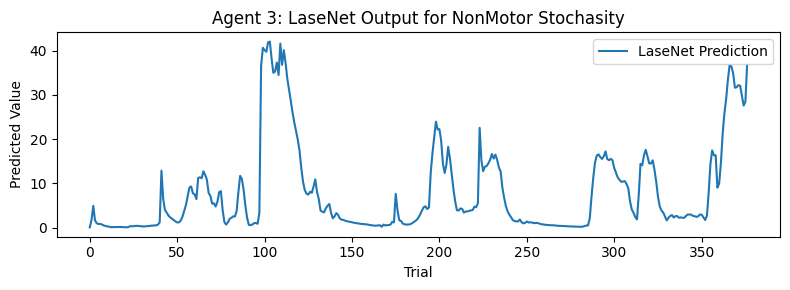

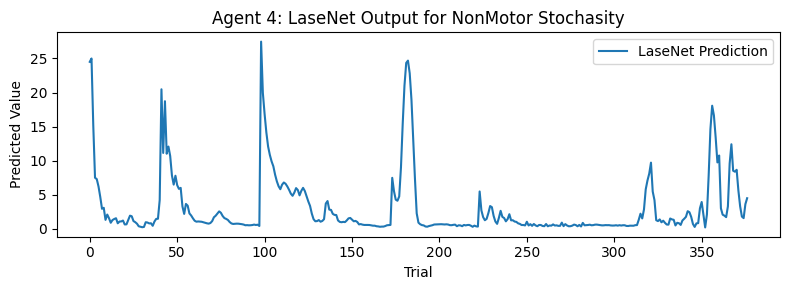

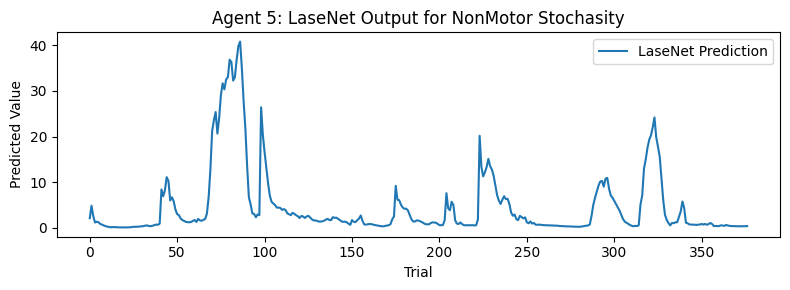

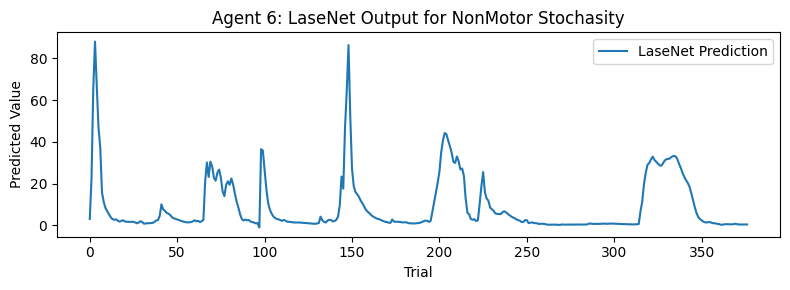

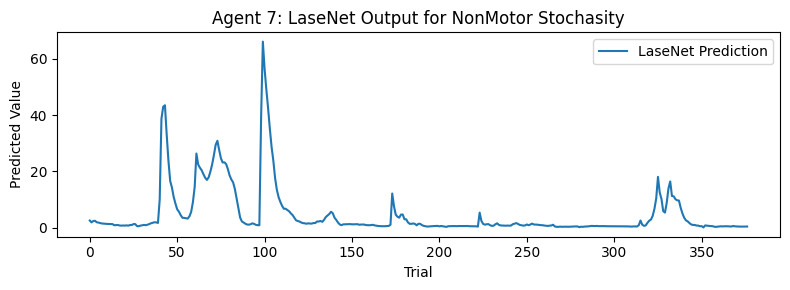

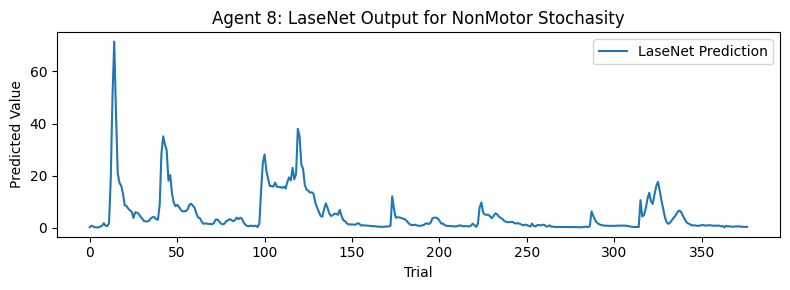

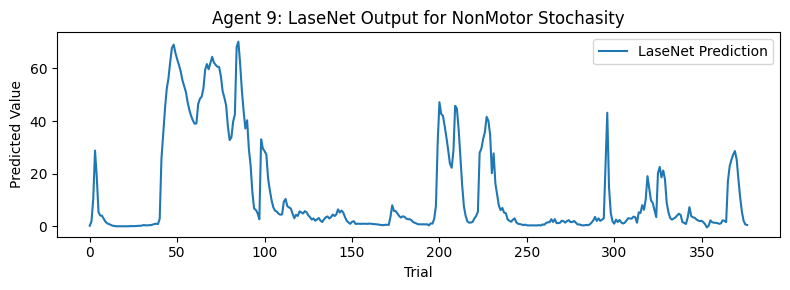

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get actual agent IDs from test_data
agent_ids = test_data["agentid"].unique()

for i in range(min(10, predicted.shape[0])):
    plt.figure(figsize=(8, 3))
    plt.plot(predicted[i], label="LaseNet Prediction")
    plt.title(f"Agent {i}: LaseNet Output for NonMotor Stochasity")
    plt.xlabel("Trial")
    plt.ylabel("Predicted Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np

# 1. Load actions from Google Drive Excel (columns = agents, rows = trials)
actions_df = pd.read_excel("/content/gdrive/MyDrive/LaseNets/Motor_LVLS.xlsx", header=None)
actions_trimmed = actions_df.T.to_numpy() * 10000 / (-270)  # Shape: (n_agents, n_trials)

# 2. Get rewards from your original test_data (already aligned and trimmed)
# Assuming test_data is sorted by agentid and trials
rewards_df = data.pivot(index="trials", columns="agentid", values="rewards")
rewards_trimmed = rewards_df.T.to_numpy()  # Shape: (n_agents, n_trials)
rewards_trimmed = rewards_trimmed[:17]
print(actions_trimmed.shape)
print(rewards_trimmed.shape)
# 3. Stack features along last axis to match (n_agents, n_trials, n_features)
actions_trimmed = actions_trimmed[..., np.newaxis]  # shape: (n_agents, n_trials, 1)
rewards_trimmed = rewards_trimmed[..., np.newaxis]

X_test_new = np.concatenate([actions_trimmed, rewards_trimmed], axis=-1)
predicted = best_model.predict(X_test_new)
print(predicted.shape)
predicted_stochasity_flat = predicted.reshape(-1)
n_agents, n_trials, _ = predicted.shape
# Add identifiers (agent ID and trial number)
agent_ids = np.repeat(np.arange(n_agents), n_trials)
trial_nums = np.tile(np.arange(n_trials), n_agents)

# Combine into a DataFrame
df_out = pd.DataFrame({
    'agent_id': agent_ids,
    'trial': trial_nums,
    'predicted_stochasity': predicted_stochasity_flat
})

# Export only predicted volatility
df_out.to_excel("predicted_stochasity_Motor_Simple.xlsx", index=False)
from google.colab import files
files.download("predicted_stochasity_Motor_Simple.xlsx")


(17, 377)
(17, 377)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
(17, 377, 1)


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

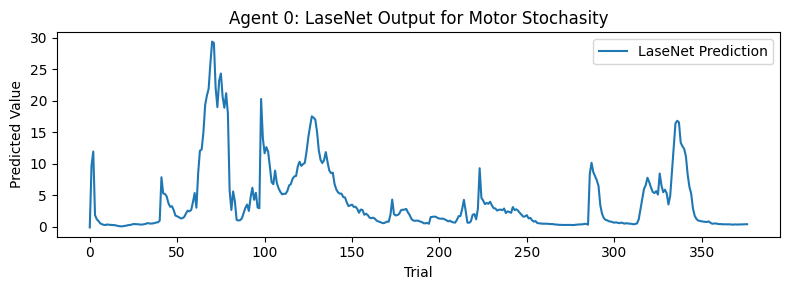

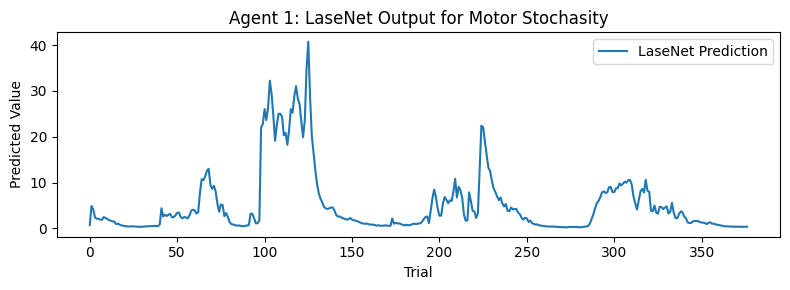

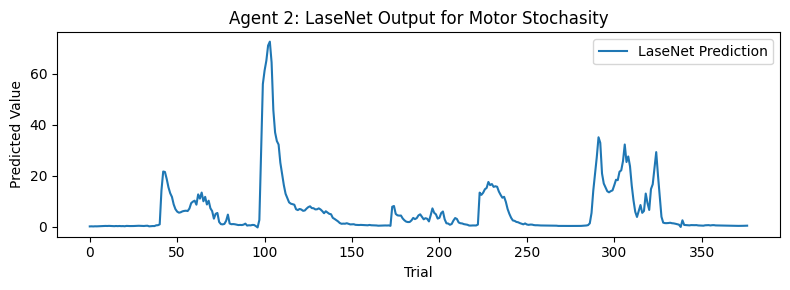

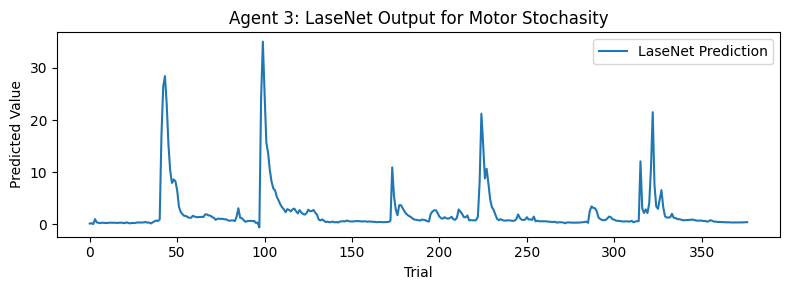

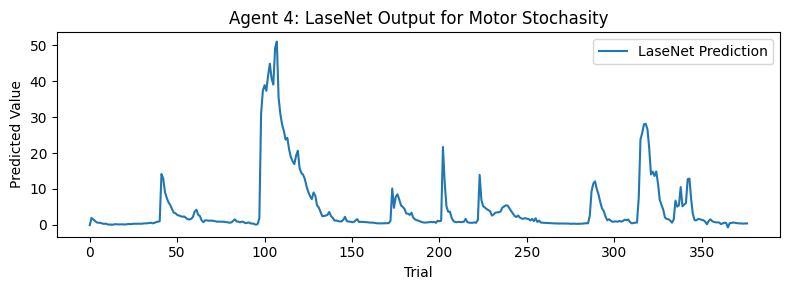

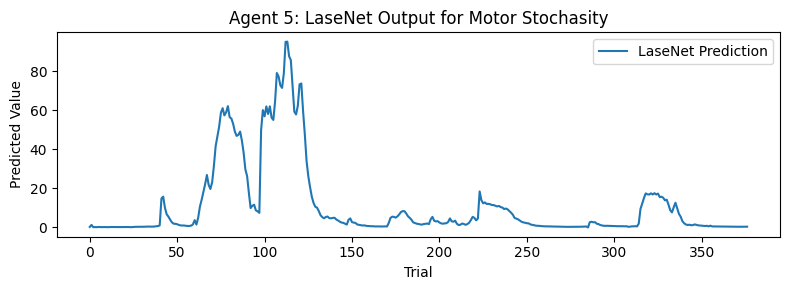

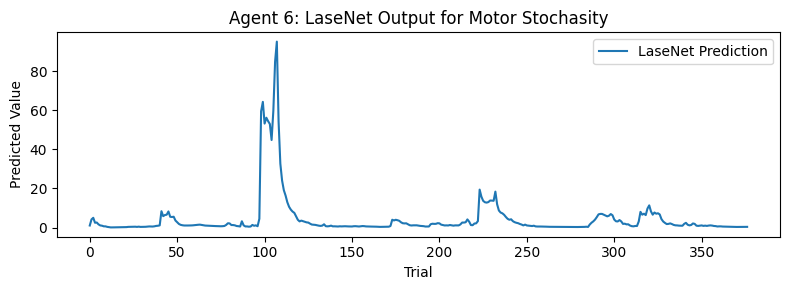

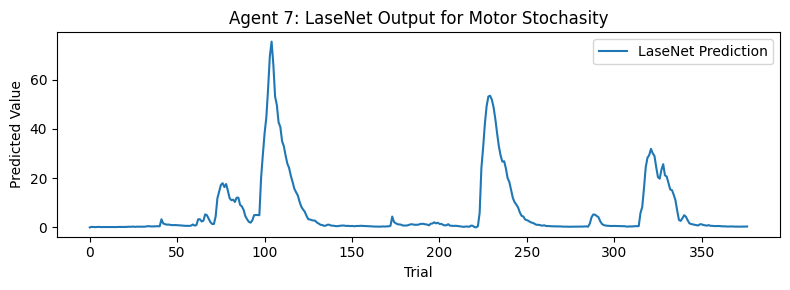

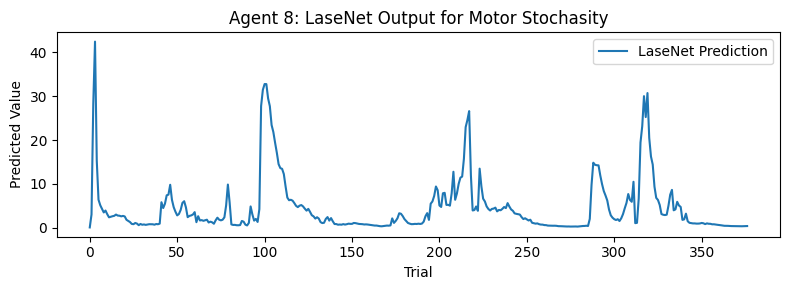

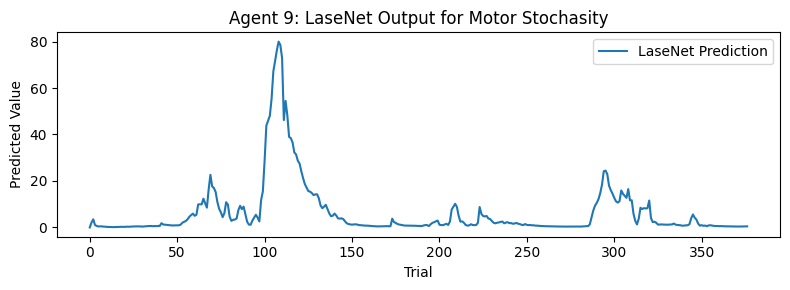

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get actual agent IDs from test_data
agent_ids = test_data["agentid"].unique()

for i in range(min(10, predicted.shape[0])):
    plt.figure(figsize=(8, 3))
    plt.plot(predicted[i], label="LaseNet Prediction")
    plt.title(f"Agent {i}: LaseNet Output for Motor Stochasity")
    plt.xlabel("Trial")
    plt.ylabel("Predicted Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Hyperparameter Tuning

In [ ]:
# For grid search
!pip install --upgrade keras-hypetune
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.0/966.0 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: hyperopt
    Found existing installation: hyperopt 0.2.7
    Uninstalling hyperopt-0.2.7:
      Successfully uninstalled hyperopt-0.2.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
def get_model(parms):
    lasenet = create_model(
        parms["feature_dim"],
        parms["discrete_output_dim"],
        parms["continuous_output_dim"],
        parms["units"],
        parms["dropout"],
        parms["dropout1"],
        parms["dropout2"],
    )
    optimizer = Adam(learning_rate=parms["learning_rate"])
    lasenet.compile(
        loss={
            "continuous_latent": "mse",
        },
        loss_weights={"continuous_latent": 1},
        optimizer=optimizer,
    )
    return lasenet

In [ ]:
from kerashypetune import KerasBayesianSearch
from hyperopt import hp, Trials

param_grid = {
  'feature_dim': X_train.shape[-1],
  'continuous_output_dim': 1,
  'discrete_output_dim': 0,
  'units': hp.choice('units', [96, 128, 256]),
  'learning_rate': 3e-4,
  'dropout': hp.uniform('dropout', .05, .25),
  'dropout1': hp.uniform('dropout1', .01, .1),
  'dropout2': hp.uniform('dropout2', .01, .05),
  'epochs': 100,
  'batch_size': 128,
}

n_iter = 10 # We set it to 10 in our work
kbs = KerasBayesianSearch(get_model, param_grid, monitor='val_loss', greater_is_better=False, n_iter=n_iter, sampling_seed=33)
callbacks = [EarlyStopping(monitor='val_loss', patience=25)]
kbs.search(
    X_train,
    y_train,
    trials=Trials(),
    validation_data=(X_val, y_val),
    callbacks=callbacks)

print(kbs.best_params)
print(kbs.scores)


10 trials detected for ('feature_dim', 'continuous_output_dim', 'discrete_output_dim', 'units', 'learning_rate', 'dropout', 'dropout1', 'dropout2', 'epochs', 'batch_size')

***** (1/10) *****
Search({'batch_size': 128, 'continuous_output_dim': 1, 'discrete_output_dim': 0, 'dropout': 0.12492302802998448, 'dropout1': 0.012615786263324952, 'dropout2': 0.026895223609922816, 'epochs': 100, 'feature_dim': 420, 'learning_rate': 0.0003, 'units': 256})
SCORE: 0.00447 at epoch 48

***** (2/10) *****
Search({'batch_size': 128, 'continuous_output_dim': 1, 'discrete_output_dim': 0, 'dropout': 0.16332624338678303, 'dropout1': 0.06512288262344043, 'dropout2': 0.014747207795025793, 'epochs': 100, 'feature_dim': 420, 'learning_rate': 0.0003, 'units': 96})
SCORE: 0.00625 at epoch 66

***** (3/10) *****
Search({'batch_size': 128, 'continuous_output_dim': 1, 'discrete_output_dim': 0, 'dropout': 0.1978495187287711, 'dropout1': 0.08612694583579543, 'dropout2': 0.02194709944897523, 'epochs': 100, 'feature_d